In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

# from seaborn import despine
import matplotlib.pyplot as plt
plt.rc("axes.spines", top=False, right=False)

from analysis_functions import compute_gaze_influence, sci_notation, run_linear_model, compute_mean_rt, compute_p_choose_best, write_summary, make_sure_path_exists

In [2]:
make_sure_path_exists('results/linear_models')

In [3]:
np.random.seed(52) # from random.org

# Absolute model fit (out of sample prediction)
## Like and dislike condition

In [4]:
print('Assessing absolute model fit...')

Assessing absolute model fit...


### Load plot function

In [5]:
def plot_correlation(x_in, y,
                     model_names=None,
                     xlabel='',
                     ylabel='',
                     title='',
                     ci=0.95,
                     xticks=None,
                     yticks=None,
                     xticklabels=None,
                     yticklabels=None,
                     xlim=None,
                     ylim=None,
                     annotation_pos=(0.1, 0.1),
                     annotation_halign='left',
                     fontsize_title=15,
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_annotation=12,
                     plot_diagonal=False,
                     ax=None):
    
    
    x_all = x_in
    color_code = ['#4F6A9A', '#AC5255']
    # Defaults
    if ax is None:
        fig, ax = plt.subplots()
    if not isinstance(x_in, list):
        x_all = [x_in]
    if not isinstance(y, list):
        y = [y]
    if model_names is None:
        model_names = ['Model {}'.format(i)
                       for i in range(len(y))]
    
    for i, yi in enumerate(y):
        
        # Select if we load the set of observed items for like (0) or dislike (1)
        # This will depend on how we define it later.
        x = x_all[i]
        
        # Scatter
        ax.scatter(x, yi, color=color_code[i], alpha=0.5)

        # LM fit
        X = sm.add_constant(x)
        lm = sm.OLS(yi, X).fit()
        intercept, slope = lm.params
        table, data, columns = summary_table(lm, alpha=1.-ci)
        predicted, mean_ci_lower, mean_ci_upper = data[:, np.array([2, 4, 5])].T

         # Annotation
        tval = lm.tvalues[-1]
        pval = lm.pvalues[-1]
        if pval < 0.01:
            pstring = ' < ' + sci_notation(pval, decimal_digits=2)
        else:
            pstring = ' = {:.2f}'.format(pval)
        r = np.sign(tval) * np.sqrt(lm.rsquared)
        label = ((r'$r = {:.2f}$, '.format(r)) +
                  r'$P${}'.format(pstring))
        xs = np.linspace(*ax.get_xlim(), 100)
        ax.plot(xs, intercept + slope * xs,
                color=color_code[i], label=label)
        sort_idx = np.argsort(x)
        ax.fill_between(x[sort_idx], mean_ci_lower[sort_idx], mean_ci_upper[sort_idx],
                        color=color_code[i], alpha=0.1)

    ax.legend(loc='best', fontsize=fontsize_annotation, frameon=False)

    # Axes, ticks, ...
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
        
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, fontsize=fontsize_ticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels, fontsize=fontsize_ticklabels)

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Diagonal
    if plot_diagonal:
        ax.plot([0, 1], [0, 1], transform=ax.transAxes,
                color='black', alpha=.5, zorder=-10, lw=2)

    # Labels
    ax.set_xlabel(xlabel, fontsize=fontsize_axeslabel)
    ax.set_ylabel(ylabel, fontsize=fontsize_axeslabel)
    ax.set_title(title, fontsize=fontsize_title)
#     despine()

    return ax

## Load *observed* data (test set) GLAM out of sample *predictions*

In [6]:
#Like
test_data_L = pd.read_csv('data/FF2018_data/GlamDataFF2018_preprocessed_test_Like_NoBin_NUTS_31.csv')
glam_full_L = pd.read_csv('results/predictions/glam_FF2018_full_hierarchical_cv_Like_NoBin_NUTS_31.csv')

#Dislike
test_data_D = pd.read_csv('data/FF2018_data/GlamDataFF2018_preprocessed_test_Dislike_NoBin_Dislike_NUTS_Inv_31.csv')
glam_full_D = pd.read_csv('results/predictions/glam_FF2018_full_hierarchical_cv_Dislike_NoBin_Dislike_NUTS_Inv_31.csv')


# Compute behavioral indices for observed data and predictions

In [7]:
mean_rt = pd.DataFrame(dict(observed_L=compute_mean_rt(test_data_L),
                            observed_D=compute_mean_rt(test_data_D),
                            glam_full_L=compute_mean_rt(glam_full_L),
                            glam_full_D=compute_mean_rt(glam_full_D)))
                            
p_choose_best = pd.DataFrame(dict(observed_L=compute_p_choose_best(test_data_L),
                            observed_D=compute_p_choose_best(test_data_D),
                            glam_full_L=compute_p_choose_best(glam_full_L),
                            glam_full_D=compute_p_choose_best(glam_full_D)))

gaze_influence = pd.DataFrame(dict(observed_L=compute_gaze_influence(test_data_L),
                                   observed_D=compute_gaze_influence(test_data_D),
                                   glam_full_L=compute_gaze_influence(glam_full_L),
                                  glam_full_D=compute_gaze_influence(glam_full_D)))

## Linear models: Are out of sample data predicted by GLAM variants?

### 1. Like

#### 1.1 Mean RT

In [8]:
print('  1. Full GLAM...')
print('  1.1 Mean RT')
_ = run_linear_model(mean_rt['glam_full_L'],
                     mean_rt['observed_L'])
write_summary(_, 'results/linear_models/like/3_absfit_like_rt.csv')

  1. Full GLAM...
  1.1 Mean RT
                            OLS Regression Results                            
Dep. Variable:             observed_L   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     294.3
Date:                Mon, 18 Feb 2019   Prob (F-statistic):           1.00e-16
Time:                        14:21:50   Log-Likelihood:                -214.38
No. Observations:                  31   AIC:                             432.8
Df Residuals:                      29   BIC:                             435.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -526.

#### 1.2 P(choose best)

In [9]:
print('  1.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_full_L'],
                     p_choose_best['observed_L'])
write_summary(_, 'results/linear_models/like/3_absfit_like_pchoosebest.csv')

  1.2 P(choose best)
                            OLS Regression Results                            
Dep. Variable:             observed_L   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     85.91
Date:                Mon, 18 Feb 2019   Prob (F-statistic):           3.59e-10
Time:                        14:21:50   Log-Likelihood:                 48.305
No. Observations:                  31   AIC:                            -92.61
Df Residuals:                      29   BIC:                            -89.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0188      0

#### 1.3 Gaze influence on P(choose left)

In [10]:
print('  1.3 Gaze Influence')
_ = run_linear_model(gaze_influence['glam_full_L'],
                     gaze_influence['observed_L'])
write_summary(_, 'results/linear_models/like/3_absfit_like_gazeinfluence.csv')

  1.3 Gaze Influence
                            OLS Regression Results                            
Dep. Variable:             observed_L   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     43.22
Date:                Mon, 18 Feb 2019   Prob (F-statistic):           3.34e-07
Time:                        14:21:50   Log-Likelihood:                 18.920
No. Observations:                  31   AIC:                            -33.84
Df Residuals:                      29   BIC:                            -30.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0956      0

### 2. Dislike GLAM

#### 2.1 Mean RT

In [11]:
print('  2. No-Bias GLAM')
print('  2.1 Mean RT')
_ = run_linear_model(mean_rt['glam_full_D'],
                     mean_rt['observed_D'])
write_summary(_, 'results/linear_models/like/3_absfit_dislike_rt.csv')

  2. No-Bias GLAM
  2.1 Mean RT
                            OLS Regression Results                            
Dep. Variable:             observed_D   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     156.1
Date:                Mon, 18 Feb 2019   Prob (F-statistic):           3.38e-13
Time:                        14:21:50   Log-Likelihood:                -218.95
No. Observations:                  31   AIC:                             441.9
Df Residuals:                      29   BIC:                             444.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          86.

#### 2.2 P(choose best)

In [12]:
print('  2.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_full_D'],
                     p_choose_best['observed_D'])
write_summary(_, 'results/linear_models/like/3_absfit_dislike_pchoosebest.csv')

  2.2 P(choose best)
                            OLS Regression Results                            
Dep. Variable:             observed_D   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     62.94
Date:                Mon, 18 Feb 2019   Prob (F-statistic):           9.48e-09
Time:                        14:21:50   Log-Likelihood:                 42.288
No. Observations:                  31   AIC:                            -80.58
Df Residuals:                      29   BIC:                            -77.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0693      0

#### 2.3 Gaze influence on P(choose left)

In [13]:
print('  2.3 Gaze influence')
_ = run_linear_model(gaze_influence['glam_full_D'],
                     gaze_influence['observed_D'])
write_summary(_, 'results/linear_models/like/3_absfit_dislike_gazeinfluence.csv')

  2.3 Gaze influence
                            OLS Regression Results                            
Dep. Variable:             observed_D   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     35.19
Date:                Mon, 18 Feb 2019   Prob (F-statistic):           1.92e-06
Time:                        14:21:50   Log-Likelihood:                 16.380
No. Observations:                  31   AIC:                            -28.76
Df Residuals:                      29   BIC:                            -25.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0441      0

In [14]:
def figure_5(mean_rt, p_choose_best, gaze_influence, figsize=(10, 3.5)):

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    plot_correlation([mean_rt['observed_L'].values, mean_rt['observed_D'].values], 
                     [mean_rt['glam_full_L'].values, mean_rt['glam_full_D'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='Mean RT (ms)',
                     xlim=[0, 6500],
                     ylim=[0, 6500],
                     xticks=np.arange(0, 7000, 1000),
                     yticks=np.arange(0, 7000, 1000),
                     xticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     yticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[0], plot_diagonal=True)

    plot_correlation([p_choose_best['observed_L'].values, p_choose_best['observed_D'].values],
                     [p_choose_best['glam_full_L'].values, p_choose_best['glam_full_D'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='P(choose best)',
                     xlim=[0.45, 1.05],
                     ylim=[0.45, 1.05],
                     xticks=np.arange(0.4, 1.1, 0.1),
                     yticks=np.arange(0.4, 1.1, 0.1),
                     xticklabels=['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                     yticklabels=['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[1], plot_diagonal=True)

    plot_correlation([gaze_influence['observed_L'].values, gaze_influence['observed_D'].values],
                     [gaze_influence['glam_full_L'].values, gaze_influence['glam_full_D'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='Gaze influence\non P(choose left)',
                     xticks=np.arange(-0.1, 0.7, 0.1),
                     yticks=np.arange(-0.1, 0.7, 0.1),
                     xticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     yticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     xlim=[-0.125, 0.625],
                     ylim=[-0.125, 0.625],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[2], plot_diagonal=True)

    # index axes
 #   for label, ax in zip(list('ABC'), axs.ravel()):
 #       ax.text(-0.1, 1.15, label, transform=ax.transAxes,
 #               fontsize=20, fontweight='bold', va='top')

    fig.tight_layout()

    return None

Close Figure to continue...


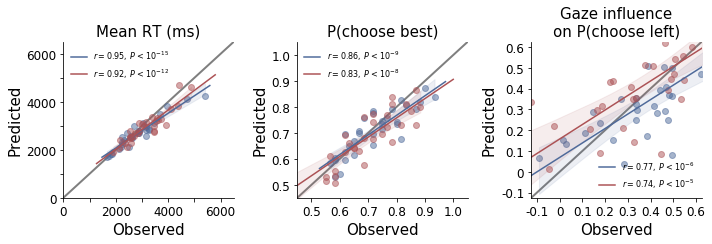

In [15]:
print('Close Figure to continue...')
figure_5(mean_rt, p_choose_best, gaze_influence)
#plt.savefig('SavedFigures/Like_model_fit_simulations.png', dpi=330, bbox_inches='tight')
plt.show()

Model predictions are simulated from hierarchically estimated parameter estimates. Blue color indicates predictions from the full GLAM, whereas orange indicates predictions from a restricted GLAM variant with no gaze bias (gamma = 1).


## ---------------------------------------------